## RFC Testing

First thing that is to be done is to import the data and generate splits

In [5]:
import sys
sys.path.append('../')

from prep import *
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier

# Load data
df = pd.read_csv('../../Datasets/train.csv', encoding='cp1252')

# Do some basic cleaning
df = prep_data(df)

processing = 'none'

if processing in ['basic', 'common_words', 'word_replacement', 'mutual']:
    df = prep_data(df)

# Split data using KFold
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define the pipeline
pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer(max_features=3000)),
    ('classifier', OneVsRestClassifier(RandomForestClassifier(random_state=42, ))) 
])

parameters = {
    'vectorizer__ngram_range': [(1, 1), (1, 2)], 
    'classifier__estimator__n_estimators': [50, 100],  
    'classifier__estimator__max_depth': [20, 30, 50],
}
# Make list to store accuracies
test_acc = []
y_preds = []
y_vals = []

# Iterate through folds
for train_index, val_index in kf.split(df['body'], df['subreddit']):
    # Split data
    train = df.iloc[train_index]
    val = df.iloc[val_index]
    vocab = build_vocab(train)

    if processing in ['word_replacement']:
        val = word_replacement(val)
        train = word_replacement(train)

    # Reduce features based on mutual information
    subreddits = ['Toronto', 'London', 'Paris', 'Montreal']

    if processing in ['common_words', 'mutual', 'word_replacement']:
        train, vocab = remove_common_words(train, subreddits, 300)

    if processing in ['mutual', 'word_replacement']:
        train = mutual_info_transform(train, 3250)
        train, vocab = remove_common_words(train, subreddits, 25)

    # Remove words not in vocab from val
    val['body'] = val['body'].apply(lambda x: ' '.join([word for word in x.split() if word in vocab]))

    # Split into X and y
    X_train = train['body']
    y_train = train['subreddit']
    y_train = y_train.map({'Toronto': 0, 'London': 1, 'Paris': 2, 'Montreal': 3})
    X_val = val['body']
    y_val = val['subreddit']
    y_val = y_val.map({'Toronto': 0, 'London': 1, 'Paris': 2, 'Montreal': 3})

    # Perform grid search
    grid_search = GridSearchCV(pipeline, parameters, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
    grid_search.fit(X_train, y_train)
    print(grid_search.best_params_)

    # Evaluate on validation set
    y_vals.extend(y_val)
    y_preds.extend(grid_search.predict(X_val))
    test_acc.append(grid_search.score(X_val, y_val))

    # Print accuracy
    print(f'Accuracy: {test_acc[-1]}')

test_acc = np.mean(test_acc)
print(f'Average accuracy: {test_acc}')

Fitting 5 folds for each of 12 candidates, totalling 60 fits
{'classifier__estimator__max_depth': 30, 'classifier__estimator__n_estimators': 100, 'vectorizer__ngram_range': (1, 1)}
Accuracy: 0.6597222222222222
Fitting 5 folds for each of 12 candidates, totalling 60 fits
{'classifier__estimator__max_depth': 30, 'classifier__estimator__n_estimators': 100, 'vectorizer__ngram_range': (1, 1)}
Accuracy: 0.6666666666666666
Fitting 5 folds for each of 12 candidates, totalling 60 fits
{'classifier__estimator__max_depth': 20, 'classifier__estimator__n_estimators': 100, 'vectorizer__ngram_range': (1, 2)}
Accuracy: 0.6597222222222222
Fitting 5 folds for each of 12 candidates, totalling 60 fits
{'classifier__estimator__max_depth': 50, 'classifier__estimator__n_estimators': 100, 'vectorizer__ngram_range': (1, 2)}
Accuracy: 0.6458333333333334
Fitting 5 folds for each of 12 candidates, totalling 60 fits
{'classifier__estimator__max_depth': 50, 'classifier__estimator__n_estimators': 100, 'vectorizer__n

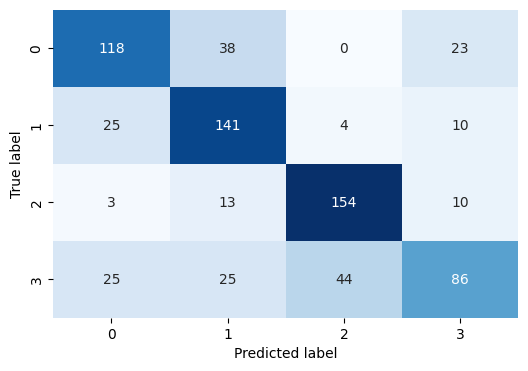

In [2]:
from prep import plot_conf_mat
from sklearn.metrics import confusion_matrix

# Plot overall confusion matrix with proper city names
conf_mat = confusion_matrix(y_vals, y_preds)
plot_conf_mat(conf_mat)

In [3]:
# Retrain on full dataset and test on Kaggle test set
kaggle_test = pd.read_csv('../../Datasets/Kaggle/test.csv', encoding='cp1252')
test_body = kaggle_test['body'].copy()
kaggle_test = prep_data(kaggle_test)
kaggle_test = word_replacement(kaggle_test)

test_df = df.copy()

# Reduce features based on mutual information
subreddits = ['Toronto', 'London', 'Paris', 'Montreal']
test_df = word_replacement(test_df)
test_df, _ = remove_common_words(test_df, subreddits, 300)
test_df = mutual_info_transform(test_df, 3250)
test_df, vocab = remove_common_words(test_df, subreddits, 25)

# Remove words not in vocab from kaggle test set
kaggle_test['body'] = kaggle_test['body'].apply(lambda x: ' '.join([word for word in x.split() if word in vocab]))

# Split into X and y
X_train = test_df['body']
y_train = test_df['subreddit']

# Fit on full training set
pipeline.fit(X_train, y_train)

# Make predictions on test set
X_test = kaggle_test['body']
y_pred = pipeline.predict(X_test)

# Make submission file
submission = generate_kaggle_submission(kaggle_test, y_pred)
submission.to_csv('../../Datasets/Kaggle/submission.csv', index=False)

# Make an array that says "Toronto" 70 times, "London" 70 times, etc.
test_acc = np.array(['Toronto'] * 69 + ['London'] * 70 + ['Paris'] * 70 + ['Montreal'] * 70)
acc = np.mean([test_acc == y_pred])

print(f'Accuracy on Kaggle test set: {acc}')

Accuracy on Kaggle test set: 0.6810035842293907
